<a href="https://colab.research.google.com/github/kridtapon/TSI-CCI-Fusion/blob/main/WFO_TSI_CCI_Fusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.6/527.6 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 50.0 MB/s eta 0:00:00


In [2]:
pip install --upgrade yfinance

[*********************100%***********************]  1 of 1 completed
<ipython-input-5-d23b63b199e0>:46: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-5-d23b63b199e0>:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-5-d23b63b199e0>:46: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in


Walk-Forward Optimization Results:
   Year   Best_Params  Test_Return
0  2020  (34, 20, 28)     0.012243
1  2021  (32, 18, 12)     0.187597
2  2022  (32, 18, 10)    -0.014126
3  2023  (32, 18, 10)    -0.001354
4  2024  (32, 18, 10)    -0.036056
5  2025  (30, 19, 22)     0.000000


<ipython-input-5-d23b63b199e0>:118: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-5-d23b63b199e0>:117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-5-d23b63b199e0>:118: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-5-d23b6

Start                          2020-01-02 00:00:00
End                            2024-12-31 00:00:00
Period                          1258 days 00:00:00
Start Value                               100000.0
End Value                            114365.183028
Total Return [%]                         14.365183
Benchmark Return [%]                     35.217929
Max Gross Exposure [%]                       100.0
Total Fees Paid                         3142.89334
Max Drawdown [%]                         24.711973
Max Drawdown Duration            678 days 00:00:00
Total Trades                                    15
Total Closed Trades                             14
Total Open Trades                                1
Open Trade PnL                        13060.365806
Win Rate [%]                             42.857143
Best Trade [%]                             9.84595
Worst Trade [%]                          -5.978139
Avg Winning Trade [%]                     4.255369
Avg Losing Trade [%]           

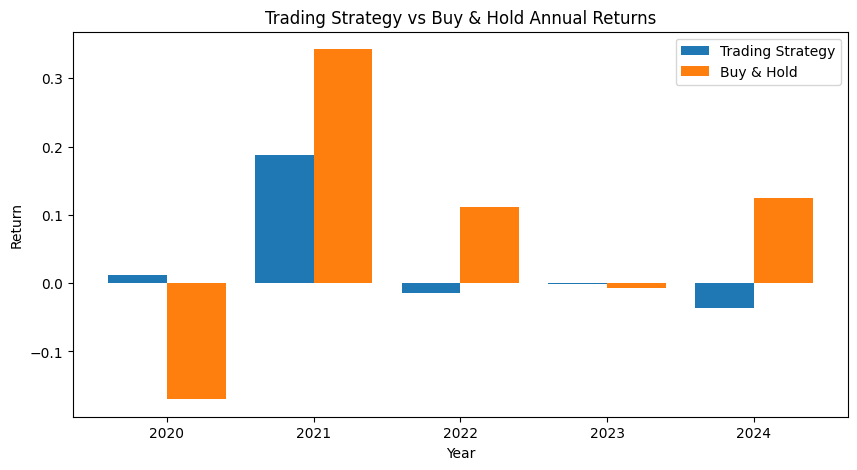

In [5]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
import itertools
import matplotlib.pyplot as plt

# TSI Calculation
def calculate_tsi(close, long=25, short=13):
    momentum = close.diff()
    abs_momentum = momentum.abs()
    ema1 = momentum.ewm(span=short).mean()
    ema2 = ema1.ewm(span=long).mean()
    abs_ema1 = abs_momentum.ewm(span=short).mean()
    abs_ema2 = abs_ema1.ewm(span=long).mean()
    tsi = 100 * (ema2 / abs_ema2)
    return tsi

# CCI Calculation
def calculate_cci(df, period=20):
    tp = (df['High'] + df['Low'] + df['Close']) / 3
    sma = tp.rolling(window=period).mean()
    mad = tp.rolling(window=period).apply(lambda x: np.fabs(x - x.mean()).mean())
    cci = (tp - sma) / (0.015 * mad)
    return cci

# Walk-forward optimization with TSI and CCI
def walk_forward_optimization_tsi_cci(df, start_year, end_year):
    results = []

    tsi_long_range = range(10, 36, 2)
    tsi_short_range = range(5, 21)
    cci_period_range = range(10, 31, 2)

    for test_year in range(start_year + 4, end_year + 1):
        train_start = test_year - 4
        train_end = test_year - 1

        train_data = df[(df.index.year >= train_start) & (df.index.year <= train_end)]
        test_data = df[df.index.year == test_year]

        best_params = None
        best_performance = -np.inf

        for long, short, cci_period in itertools.product(tsi_long_range, tsi_short_range, cci_period_range):
            train_data['TSI'] = calculate_tsi(train_data['Close'], long=long, short=short)
            train_data['CCI'] = calculate_cci(train_data, period=cci_period)

            entries = (train_data['TSI'] > 0) & (train_data['CCI'] > -100)
            exits = (train_data['TSI'] < 0) & (train_data['CCI'] < 100)

            portfolio = vbt.Portfolio.from_signals(
                close=train_data['Close'],
                entries=entries,
                exits=exits,
                init_cash=100_000,
                fees=0.001,
                slippage=0.002,
                freq='D'
            )

            performance = portfolio.total_return()
            if performance > best_performance:
                best_performance = performance
                best_params = (long, short, cci_period)

        # Use best params on test year
        yearly_data = df[(df.index.year >= test_year - 1) & (df.index.year <= test_year)]
        yearly_data['TSI'] = calculate_tsi(yearly_data['Close'], long=best_params[0], short=best_params[1])
        yearly_data['CCI'] = calculate_cci(yearly_data, period=best_params[2])
        yearly_data = yearly_data[yearly_data.index.year == test_year]

        entries = (yearly_data['TSI'] > 0) & (yearly_data['CCI'] > -100)
        exits = (yearly_data['TSI'] < 0) & (yearly_data['CCI'] < 100)

        portfolio = vbt.Portfolio.from_signals(
            close=yearly_data['Close'],
            entries=entries,
            exits=exits,
            init_cash=100_000,
            fees=0.001,
            slippage=0.002,
            freq='D'
        )

        results.append({
            'Year': test_year,
            'Best_Params': best_params,
            'Test_Return': portfolio.total_return()
        })

    return pd.DataFrame(results)

# Download stock data
symbol = 'CNP' # APO META! TRGP! TPL! UAL! BTC-USD CNP NEM! T!
start_date = '2015-01-01'
end_date = '2025-01-01'
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# Run optimization
results = walk_forward_optimization_tsi_cci(df, 2016, 2025)

# Print results
print("\nWalk-Forward Optimization Results:")
print(results)

# Combine signals for all test years
combined_entries = pd.Series(False, index=df.index)
combined_exits = pd.Series(False, index=df.index)

for _, row in results.iterrows():
    year = row['Year']
    long, short, cci_period = row['Best_Params']

    yearly_data = df[(df.index.year >= year - 1) & (df.index.year <= year)]
    yearly_data['TSI'] = calculate_tsi(yearly_data['Close'], long=long, short=short)
    yearly_data['CCI'] = calculate_cci(yearly_data, period=cci_period)
    yearly_data = yearly_data[yearly_data.index.year == year]

    entries = (yearly_data['TSI'] > 0) & (yearly_data['CCI'] > -100)
    exits = (yearly_data['TSI'] < 0) & (yearly_data['CCI'] < 100)

    combined_entries.loc[entries.index] = entries
    combined_exits.loc[exits.index] = exits

# Filter data for testing period only
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]
combined_entries = combined_entries[(combined_entries.index.year >= 2020) & (combined_entries.index.year <= 2025)]
combined_exits = combined_exits[(combined_exits.index.year >= 2020) & (combined_exits.index.year <= 2025)]

# Final backtest
portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=combined_entries,
    exits=combined_exits,
    init_cash=100_000,
    fees=0.001,
    slippage=0.002,
    freq='D'
)

# Parameters
risk_free_rate = 0.02  # Annual risk-free rate, e.g., 2%

# Get core metrics
car = portfolio.annualized_return()
vol = portfolio.annualized_volatility()
max_dd = abs(portfolio.max_drawdown())

# Adjusted CAR using Sharpe-style formula (based on volatility)
adj_car_sharpe = (car - risk_free_rate) / vol if vol != 0 else np.nan

# Adjusted CAR using Calmar-style formula (based on drawdown)
adj_car_calmar = car / max_dd if max_dd != 0 else np.nan

# Initialize variables to track exposure calculation
in_position = False
exposure_days = 0
total_days = len(df)

# Loop through the entries and exits to calculate exposure
for i in range(1, len(df)):
    if combined_entries[i] and not in_position:  # Entry signal (enter position)
        in_position = True
        entry_day = i  # Track entry day
    elif combined_exits[i] and in_position:  # Exit signal (exit position)
        in_position = False
        exit_day = i  # Track exit day
        exposure_days += exit_day - entry_day  # Count days in position

# If the last position is still open (i.e., no exit signal), consider the last day of the dataset
if in_position:
    exposure_days += total_days - entry_day  # Count remaining days in position

# Calculate exposure as percentage of time in position
exposure_percentage = (exposure_days / total_days) * 100

stats = portfolio.stats()
stats['CAR'] = f"{car:.2%}"
stats['Adjusted CAR (Sharpe-style)'] = f"{adj_car_sharpe:.2%}"
stats['Adjusted CAR (Calmar-style)'] = f"{adj_car_calmar:.2%}"
stats['Market Time Exposure'] = f"{exposure_percentage:.2f}%"

# Display performance metrics
print(stats)

# Plot equity curve
portfolio.plot().show()

# Get unique years in the dataset
years = sorted(df.index.year.unique())

# Store annual returns
strategy_returns = {}
buy_and_hold_returns = {}

for year in years:
    yearly_data = df[df.index.year == year]

    if not yearly_data.empty:  # Check if data exists for the year
        # Buy & Hold Return
        start_price = yearly_data.iloc[0]['Close']
        end_price = yearly_data.iloc[-1]['Close']
        buy_and_hold_return = (end_price - start_price) / start_price
        buy_and_hold_returns[year] = buy_and_hold_return

        # Strategy Return
        strategy_returns[year] = results[results['Year'] == year]['Test_Return'].values[0]

# Plot bar chart
plt.figure(figsize=(10, 5))
bar_width = 0.4
plt.bar([y - bar_width/2 for y in strategy_returns.keys()], strategy_returns.values(), width=bar_width, label="Trading Strategy")
plt.bar([y + bar_width/2 for y in buy_and_hold_returns.keys()], buy_and_hold_returns.values(), width=bar_width, label="Buy & Hold")

plt.xlabel("Year")
plt.ylabel("Return")
plt.title("Trading Strategy vs Buy & Hold Annual Returns")
plt.legend()
plt.xticks(list(strategy_returns.keys()))

plt.show()


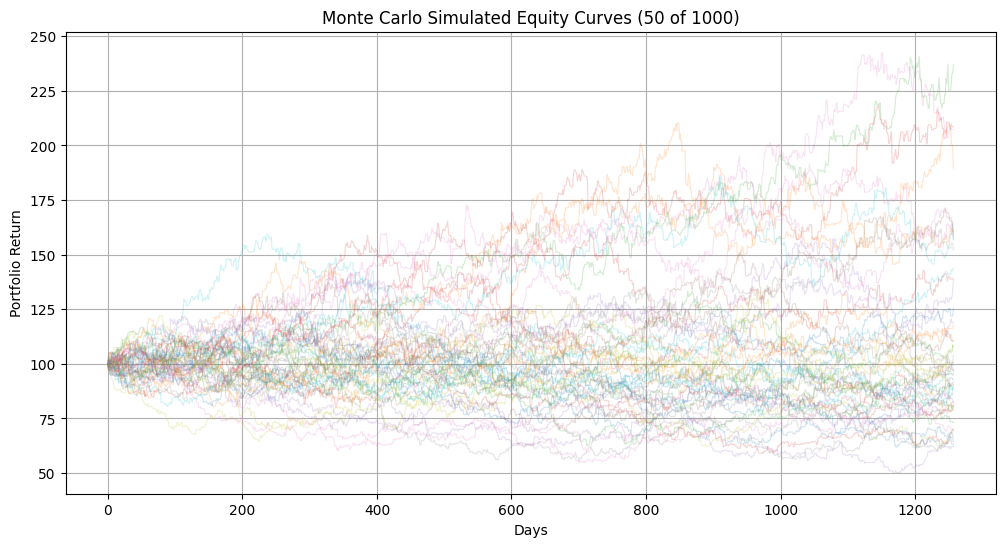

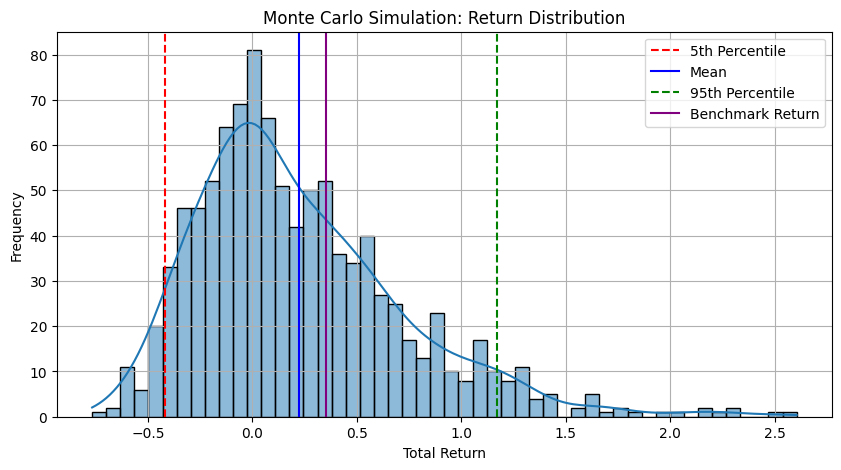

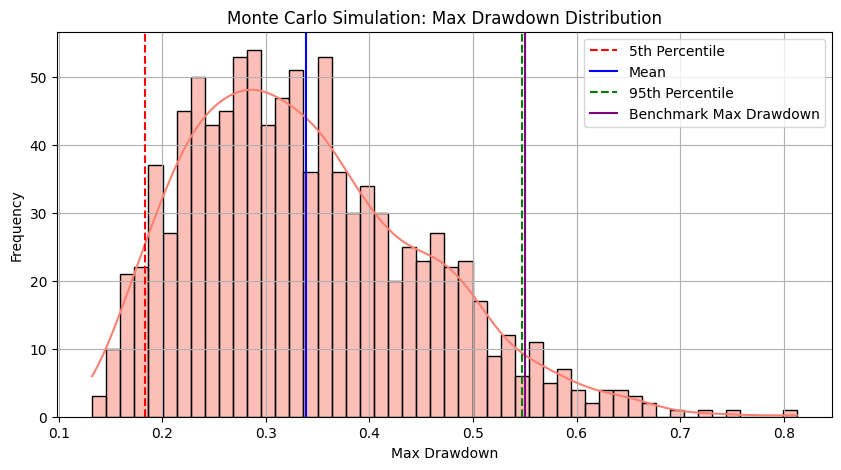

Monte Carlo Summary (1000 Simulations):
Mean Final Return: 22.33%
Median Final Return: 11.07%
5th Percentile Return: -41.71%
95th Percentile Return: 116.85%
Average Max Drawdown: 33.83%
Average Sharpe Ratio: 0.23
Number of simulations with return less than benchmark: 672
Number of simulations with max drawdown greater than benchmark: 48


In [9]:
# ------------------ ADVANCED MONTE CARLO SIMULATION ------------------
import seaborn as sns

# Parameters
n_simulations = 1000
n_days = len(portfolio.returns())
init_value = 100

# Get daily returns from the backtest
returns = portfolio.returns().copy().values  # convert to numpy

# Prepare to store metrics
equity_paths = []
drawdowns = []
final_returns = []
sharpe_ratios = []
volatilities = []

# Define Benchmark Return and Max Drawdown
benchmark_return = 0.3521
benchmark_drawdown = 0.5500

# Counters for number of simulations below benchmark return or above benchmark drawdown
below_benchmark_return_count = 0
above_benchmark_drawdown_count = 0

# Simulate full paths
for _ in range(n_simulations):
    sampled_returns = np.random.choice(returns, size=n_days, replace=True)
    equity = init_value * np.cumprod(1 + sampled_returns)

    equity_paths.append(equity)
    daily_returns = np.diff(equity) / equity[:-1]

    max_dd = np.max(1 - equity / np.maximum.accumulate(equity))
    total_return = (equity[-1] / init_value) - 1
    volatility = np.std(daily_returns)
    sharpe = np.mean(daily_returns) / (volatility + 1e-8) * np.sqrt(252)  # Avoid div by zero

    drawdowns.append(max_dd)
    final_returns.append(total_return)
    volatilities.append(volatility)
    sharpe_ratios.append(sharpe)

    # Count simulations below benchmark return and above benchmark drawdown
    if total_return < benchmark_return:
        below_benchmark_return_count += 1
    if max_dd > benchmark_drawdown:
        above_benchmark_drawdown_count += 1

# Plot: Sampled equity paths
plt.figure(figsize=(12, 6))
for i in range(50):  # only plot 50 to avoid clutter
    plt.plot(equity_paths[i], alpha=0.2, linewidth=0.8)
plt.title('Monte Carlo Simulated Equity Curves (50 of 1000)')
plt.xlabel('Days')
plt.ylabel('Portfolio Return')
plt.grid(True)
plt.show()

# Plot: Histogram of final returns with benchmark line
plt.figure(figsize=(10, 5))
sns.histplot(final_returns, bins=50, kde=True)

# Add percentile, mean, and benchmark lines
plt.axvline(np.percentile(final_returns, 5), color='red', linestyle='--', label='5th Percentile')
plt.axvline(np.mean(final_returns), color='blue', linestyle='-', label='Mean')
plt.axvline(np.percentile(final_returns, 95), color='green', linestyle='--', label='95th Percentile')
plt.axvline(benchmark_return, color='purple', linestyle='-', label='Benchmark Return')  # Benchmark Line

plt.title('Monte Carlo Simulation: Return Distribution')
plt.xlabel('Total Return')
plt.ylabel('Frequency')
plt.grid(True)
plt.legend()
plt.show()

# Plot: Histogram of drawdowns with benchmark line
plt.figure(figsize=(10, 5))
sns.histplot(drawdowns, bins=50, kde=True, color='salmon')

# Add percentile, mean, and benchmark lines
plt.axvline(np.percentile(drawdowns, 5), color='red', linestyle='--', label='5th Percentile')
plt.axvline(np.mean(drawdowns), color='blue', linestyle='-', label='Mean')
plt.axvline(np.percentile(drawdowns, 95), color='green', linestyle='--', label='95th Percentile')
plt.axvline(benchmark_drawdown, color='purple', linestyle='-', label='Benchmark Max Drawdown')  # Benchmark Line

plt.title('Monte Carlo Simulation: Max Drawdown Distribution')
plt.xlabel('Max Drawdown')
plt.ylabel('Frequency')
plt.grid(True)
plt.legend()
plt.show()

# Show summary stats
print("Monte Carlo Summary (1000 Simulations):")
print(f"Mean Final Return: {np.mean(final_returns):.2%}")
print(f"Median Final Return: {np.median(final_returns):.2%}")
print(f"5th Percentile Return: {np.percentile(final_returns, 5):.2%}")
print(f"95th Percentile Return: {np.percentile(final_returns, 95):.2%}")
print(f"Average Max Drawdown: {np.mean(drawdowns):.2%}")
print(f"Average Sharpe Ratio: {np.mean(sharpe_ratios):.2f}")

# Print number of simulations below benchmark return and above benchmark max drawdown
print(f"Number of simulations with return less than benchmark: {below_benchmark_return_count}")
print(f"Number of simulations with max drawdown greater than benchmark: {above_benchmark_drawdown_count}")

In [8]:
from scipy.stats import linregress

# Calculate Alpha, Beta, and Correlation with a Buy and Hold (B&H) strategy
portfolio_returns = portfolio.returns()
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]
df_holding = df['Close']
benchmark = vbt.Portfolio.from_holding(df_holding, init_cash=100_000)
benchmark_returns = benchmark.returns()

# Ensure returns are aligned
portfolio_returns, benchmark_returns = portfolio_returns.align(benchmark_returns, join='inner')

# Calculate Beta and alpha using linear regression
slope, intercept, r_value, _, _ = linregress(benchmark_returns, portfolio_returns)
beta = slope
alpha = intercept

# Calculate Correlation
correlation = portfolio_returns.corr(benchmark_returns)

# Display results
print(f"Alpha: {alpha:.4f}")
print(f"Beta: {beta:.4f}")
print(f"Correlation: {correlation:.4f}")

Alpha: 0.0000
Beta: 0.2921
Correlation: 0.5381


In [7]:
# Save WFO results and portfolio
results.to_pickle(f"portfolio_{symbol}_wfo_results.pkl")
portfolio.save(f"portfolio_{symbol}_results.pkl")

print("Results saved successfully.")

Results saved successfully.


In [6]:
# Filter Test Years
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# Buy and Hold Performance Metrics
df_holding = df['Close']
pf = vbt.Portfolio.from_holding(df_holding, init_cash=100_000 , freq='D')
print(pf.stats())

Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                         1258 days 00:00:00
Start Value                              100000.0
End Value                           135217.929009
Total Return [%]                        35.217929
Benchmark Return [%]                    35.217929
Max Gross Exposure [%]                      100.0
Total Fees Paid                               0.0
Max Drawdown [%]                        55.000064
Max Drawdown Duration           550 days 00:00:00
Total Trades                                    1
Total Closed Trades                             0
Total Open Trades                               1
Open Trade PnL                       35217.929009
Win Rate [%]                                  NaN
Best Trade [%]                                NaN
Worst Trade [%]                               NaN
Avg Winning Trade [%]                         NaN
Avg Losing Trade [%]                          NaN
